In [1]:
import psutil

def get_free_memory():
    memory = psutil.virtual_memory()
    return memory.available / (1024.0 ** 3)  # Convert bytes to gigabytes

print(f"Free CPU Memory: {get_free_memory():.2f} GB")

Free CPU Memory: 679.07 GB


In [2]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
from datasets import Dataset
import os

In [3]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit

tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = WhitespaceSplit()

In [4]:
tokenizer_path = "WordLevel_tokenizer_trained_InterPro.json"
tokenizer = tokenizer.from_file(tokenizer_path)
tokenizer.enable_truncation(512)

In [5]:
tokenizer.get_vocab_size()


544998

In [6]:
test = tokenizer.encode("WP_265490204 WP_206642677 WP_053312998 WP_251959347 WP_000076573 WP_227526754 WP_218401808 WP_106925592")
test.ids

[1, 2966, 754, 2545, 196, 9231, 2817, 7418, 2526, 2]

In [7]:
import json
with open("/home/toibazd/Most_frequent_IPs.json", "r") as f:
    ips = json.load(f)

sorted_dict = sorted(ips.items(), key=lambda x: x[1], reverse=True)
most_frequent_ips = [item[0] for item in sorted_dict[:100]]


In [8]:
print(most_frequent_ips[:10])

['IPR004090', 'IPR011701', 'IPR002514', 'IPR003719', 'IPR002155', 'IPR005750', 'IPR001001', 'IPR004604', 'IPR011603', 'IPR005252']


In [14]:
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
import csv
from tqdm.auto import tqdm
import numpy as np

data_dict = defaultdict(list)
enc = MultiLabelBinarizer()

with open("/home/toibazd/Prot2IP.tsv", "r") as tsvfile:
    reader = csv.reader(tsvfile, delimiter = "\t")
    for row in tqdm(reader):
        key = row[0].split("prot_")[1].split(".")[0]
        iprs = eval(row[1])
        

        for ip in iprs:
            if ip in most_frequent_ips:
                data_dict[key].append(ip)

one_hot_encoded = enc.fit_transform(data_dict.values())
one_hot_encoded_dict = {key: value for key, value in zip(data_dict.keys(), one_hot_encoded)}

print(len(one_hot_encoded_dict.keys()))

0it [00:00, ?it/s]

21791


In [15]:
len(one_hot_encoded_dict)

21791

In [16]:
len(one_hot_encoded)

21791

In [17]:
# Find unique numbers and their counts
unique_numbers, counts = np.unique(one_hot_encoded, return_counts=True)
all_count = 0
# Print the count of each number
for number, count in zip(unique_numbers, counts):
    all_count+=count
    print(f"Number {number}: Count {count}")
print(all_count)

Number 0: Count 2156132
Number 1: Count 22968
2179100


In [18]:
import json
with open('BERT_DNN_senteces.json', "r") as f:
    one_hot_encoded_sentences = json.load(f)

In [19]:
one_hot_encoded_sentences = {key: value for key, value in one_hot_encoded_sentences.items() if value}
len(one_hot_encoded_sentences)

100

In [20]:
matching_string = one_hot_encoded_sentences.values()
len(matching_string)

100

In [21]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

20162

In [22]:
from transformers import BertModel

# Check if CUDA is available and choose device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "/home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final_context5/"

model = BertModel.from_pretrained(model_path).cuda()
model.pooler = None
model.eval()

[2024-04-02 14:33:32,737] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Some weights of BertModel were not initialized from the model checkpoint at /home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final_context5/ and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(544998, 256, padding_idx=0)
    (position_embeddings): Embedding(512, 256)
    (token_type_embeddings): Embedding(2, 256)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [23]:
print(one_hot_encoded[1])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [24]:
batch_size = 128 # Define your batch size

embeddings = []
labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]

    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)

    # Convert lists to tensors and move to device
    input_ids = torch.tensor(input_ids_list).cuda()
    attention_mask = torch.tensor(attention_mask_list).cuda()

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
    hidden_states = outputs.last_hidden_state
    relevant_hidden_states = hidden_states[:, 5, :]  # Extract the 20th token's hidden state
    
    for j in range(len(batch_sentences)):
        # Move embeddings to CPU
        embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[4]
        labels.append(one_hot_encoded_dict[indicator])

# Ensure order in embeddings matches order in labels

# Now embeddings and labels are stored on the CPU


  0%|          | 0/158 [00:00<?, ?it/s]

In [25]:
def calculate_pos_weights(class_counts):
    pos_weights = np.ones_like(class_counts)
    
    neg_counts = [len(embeddings)-pos_count for pos_count in class_counts]
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
      pos_weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(pos_weights, dtype=torch.float)
class_counts = np.array(labels).sum(axis=0)
pos_weights = calculate_pos_weights(class_counts) 

In [26]:
pos_weights

tensor([73., 46., 98., 48., 98., 57., 97., 49., 40., 82., 75., 91., 49., 91.,
        79., 95., 90., 69., 97., 48., 95., 78., 87., 35., 92., 93., 64., 98.,
        40., 91., 96., 85., 90., 99., 99., 99., 89., 91., 99., 99., 37., 86.,
        47., 95., 34., 99., 95., 75., 97., 99., 84., 38., 98., 69., 89., 39.,
        98., 38., 99., 90., 46., 96., 99., 78., 56., 93., 73., 88., 95., 90.,
        99., 87., 62., 42., 51., 49., 97., 57., 91., 39., 33., 81., 99., 49.,
        49., 49., 88., 48., 92., 90., 99., 96., 63., 99., 99., 94., 65., 49.,
        47., 97.])

In [27]:
len(embeddings)

20162

In [28]:
len(labels)

20162

In [29]:
model.to("cpu")
torch.cuda.empty_cache()

In [30]:
import torch.nn as nn

class Classification_V0(nn.Module):
    def __init__(self, input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob):
        super(Classification_V0, self).__init__()
        self.fc1 = nn.Linear(input_dim, first_hidden)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(first_hidden, second_hidden)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(second_hidden, last_hidden)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(last_hidden, output_dim)
        
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = 256
first_hidden = 128
second_hidden = 64
last_hidden = 32
output_dim = 100
dropout_prob = 0.25

clf_model = Classification_V0(input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob)


In [31]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

batch_size = 128
def data_generator(embeddings, labels, batch_size):
    num_samples = len(embeddings)
    for i in range(0, num_samples, batch_size):
        batch_embeddings = embeddings[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        yield batch_embeddings, batch_labels

# Define optimizer and loss function
optimizer = torch.optim.Adam(clf_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.05)
criterion = torch.nn.BCEWithLogitsLoss()

In [32]:
import numpy as np

num_epochs = 10
epoch_loss = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    
    # Initialize data generator
    generator = data_generator(embeddings, labels, batch_size)
    train_loss = 0
    # Iterate over batches
    for batch_embeddings, batch_labels in tqdm(generator, desc="Training Batches", leave=False):
        
        optimizer.zero_grad()
        
        # Convert data to tensors

        batch_embeddings_tensor = torch.stack(batch_embeddings)
        batch_labels = np.array(batch_labels)
        batch_labels_tensor = torch.tensor(batch_labels, dtype = torch.float32)
        batch_labels_tensor = batch_labels_tensor.squeeze()

        
        outputs = clf_model(batch_embeddings_tensor)

        
        loss = criterion(outputs, batch_labels_tensor)

        
        train_loss+=loss.item()
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    scheduler.step()
    epoch_loss.append(train_loss/(len(embeddings)/batch_size))
    print(train_loss/(len(embeddings)/batch_size))
print("Training finished.")


Epoch 1/10:


Training Batches: 0it [00:00, ?it/s]

0.20167079902265223
Epoch 2/10:


Training Batches: 0it [00:00, ?it/s]

0.08911329147752085
Epoch 3/10:


Training Batches: 0it [00:00, ?it/s]

0.08511070518807728
Epoch 4/10:


Training Batches: 0it [00:00, ?it/s]

0.08364225365720374
Epoch 5/10:


Training Batches: 0it [00:00, ?it/s]

0.0828315413976139
Epoch 6/10:


Training Batches: 0it [00:00, ?it/s]

0.08209820132373333
Epoch 7/10:


Training Batches: 0it [00:00, ?it/s]

0.08174304266366655
Epoch 8/10:


Training Batches: 0it [00:00, ?it/s]

0.08134791548556485
Epoch 9/10:


Training Batches: 0it [00:00, ?it/s]

0.08114725811923026
Epoch 10/10:


Training Batches: 0it [00:00, ?it/s]

0.0806330398320797
Training finished.


In [33]:
with open('BERT_DNN_senteces_test.json', "r") as f:
    test_sentences = json.load(f)

In [34]:
test_sentences = {key: value for key, value in test_sentences.items() if value}
len(test_sentences)

99

In [35]:
matching_string = test_sentences.values()
len(matching_string)

99

In [36]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

4950

In [37]:
batch_size = 128 # Define your batch size
# model.cuda()
test_embeddings = []
test_labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]

    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)
    # Convert lists to tensors and move to device
    try:
        input_ids = torch.tensor(input_ids_list)
    except:
        for ins in input_ids_list:
            if len(ins)!=42:
                print(len(ins))
                print(ins)
    attention_mask = torch.tensor(attention_mask_list)

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
    hidden_states = outputs.last_hidden_state
    relevant_hidden_states = hidden_states[:, 5, :]  # Extract the 20th token's hidden state
    
    for j in range(len(batch_sentences)):
        # Move embeddings to CPU
        test_embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[4]
        test_labels.append(one_hot_encoded_dict[indicator])


  0%|          | 0/39 [00:00<?, ?it/s]

In [38]:
model.to("cpu")
torch.cuda.empty_cache()

In [39]:
clf_model.eval()

Classification_V0(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=32, out_features=100, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [109]:
generator = data_generator(test_embeddings, test_labels, batch_size)


from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
all_predictions = []
all_labels = []
all_probs = []


count = 0
for batch_embeddings, batch_labels in tqdm(generator, desc="Evaluation Batches", leave=False):
    batch_embeddings_tensor = torch.stack(batch_embeddings)
    batch_labels = np.array(batch_labels)
    
    logits = clf_model(batch_embeddings_tensor)
    predictions = torch.sigmoid(logits)
    thresholded_predictions = (predictions > 0.04).float()
    all_predictions.append(thresholded_predictions.detach().numpy())
    all_labels.append(batch_labels)
    all_probs.append(predictions.detach().numpy())


Evaluation Batches: 0it [00:00, ?it/s]

In [110]:
len(all_predictions)

39

In [111]:
len(all_labels[0])
    

128

In [112]:
print(all_predictions[0].shape)

(128, 100)


In [113]:

# Concatenate predictions and labels across all batches
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)


In [114]:
from sklearn import metrics
auc_scores = []

for i in range(all_labels.shape[1]):  # Iterate over each column
    y = all_labels[:, i]
    pred_y = all_probs[:, i]

    fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
    auc_score = metrics.auc(fpr, tpr)
    auc_scores.append(auc_score)

print("IP-centric AUC score:  ")
for idx, score in enumerate(auc_scores):
    print(idx,": ", score)

IP-centric AUC score:  
0 :  0.42179008547008545
1 :  0.4537607368147406
2 :  0.5790000000000001
3 :  0.5947741273100615
4 :  0.35792244897959186
5 :  0.5604019567679591
6 :  0.4583938568472804
7 :  0.703319587628866
8 :  0.9945880897887127
9 :  0.3007856378822985
10 :  0.5466639095671353
11 :  0.6230363139336159
12 :  0.4658041237113402
13 :  0.3549263755308207
14 :  0.3866467969709374
15 :  0.40668119099491656
16 :  0.46265744259823477
17 :  0.8476212954763983
18 :  0.4647634823826376
19 :  0.36925360824742265
20 :  0.4705877983099638
21 :  0.6548520506353686
22 :  0.823418029882478
23 :  0.8503857248590894
24 :  0.4736519658119658
25 :  0.5287428571428572
26 :  0.6293858368848153
27 :  0.271020899889208
28 :  0.674440261001856
29 :  0.3668726638816472
30 :  0.2912506051803438
31 :  0.560712096444626
32 :  0.6747356262833675
33 :  0.3291183673469388
34 :  0.33832244897959185
35 :  0.7635387755102041
36 :  0.4683348742640555
37 :  0.47036810233380966
38 :  0.5118163265306123
39 :  0.5

/home/toibazd/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


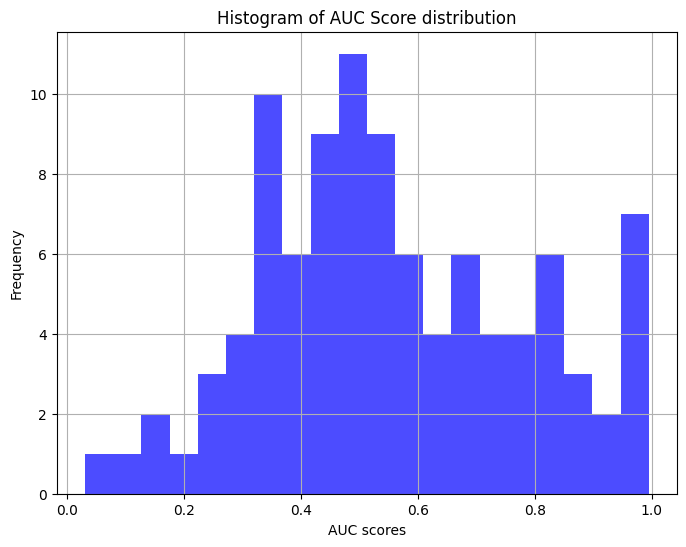

In [123]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))  # Increase the size of the plot
plt.hist(auc_scores, bins=20, color='b', alpha=0.7)  # Plot histogram with 10 bins, blue color, and transparency
plt.xlabel('AUC scores')  # Label x-axis
plt.ylabel('Frequency')  # Label y-axis
plt.title('Histogram of AUC Score distribution')  # Add a title
plt.grid(True)  # Add grid lines

plt.show()

In [115]:
all_labels.shape

(4950, 100)

In [116]:
cl_report = multilabel_confusion_matrix(all_labels, all_predictions)
print("Classification report:")
print(len(cl_report))

Classification report:
100


In [117]:
cl_report[0]

array([[4790,   85],
       [  75,    0]])

In [118]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions, zero_division=np.nan)

In [119]:
all_predictions.sum(axis=0)

array([  85.,  436.,  287.,  287.,  272.,  206.,  197.,  551.,  287.,
        197.,  188.,  287.,  321.,    0.,  287.,    0.,  325.,  197.,
        287.,  439.,    0.,  287.,    0.,  287.,  272.,    0.,  378.,
        272.,  436.,  129.,  287.,  188.,  272.,  197.,  197.,  287.,
        206.,  287.,  197.,    0.,  287.,    0.,  439.,    0.,  287.,
        287.,  188.,    0.,   49.,    0.,  188.,  197.,  272.,    0.,
          0.,  197.,    0.,  197.,   63.,  188.,  378.,  206.,  287.,
        129.,  436.,  206.,  378.,  197.,    0.,    0.,  206.,  211.,
        378.,  181.,  369.,  288.,  287.,  287.,    0.,  287., 1065.,
        272.,  263.,  466.,  378., 1061.,  197.,  439.,  287.,   76.,
        188.,    0.,  511.,  287.,  197.,  167.,  319.,  631.,  632.,
        188.], dtype=float32)

In [120]:
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.00      0.00      0.00       117
           2       0.00      0.00      0.00        50
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        50
           5       0.00      0.00      0.00        68
           6       0.00      0.00      0.00        53
           7       0.00      0.00      0.00       100
           8       1.00      0.99      1.00       289
           9       0.00      0.00      0.00        61
          10       0.00      0.00      0.00       114
          11       0.00      0.00      0.00        51
          12       0.00      0.00      0.00       100
          13        nan      0.00      0.00        51
          14       0.00      0.00      0.00        64
          15        nan      0.00      0.00        54
          16       0.00      0.00      0.00        52
          17       0.00    

In [81]:
enc.classes_[1]

'IPR000212'